## Section 1. Introduction ##

In this notebook, the dataset to be processed is the Labor Force Survey conducted April 2016 and retrieved through Philippine Statistics Authority database. 



In [39]:
import random
import numpy as np
import pickle
import os
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

# autoreload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Importing LFS PUF April 2016.CSV</h1>

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

try:
    lfs_data = pd.read_csv("LFS PUF April 2016.CSV")
except FileNotFoundError:
    print("Error: CSV file not found. Please make sure the file exists in the correct directory or provide the correct path.")
    exit()


<h1>Data Information, Pre-Processing, and Cleaning</h1>

Let's get an overview of our dataset.

In [41]:
lfs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180862 entries, 0 to 180861
Data columns (total 50 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PUFREG           180862 non-null  int64  
 1   PUFPRV           180862 non-null  int64  
 2   PUFPRRCD         180862 non-null  int64  
 3   PUFHHNUM         180862 non-null  int64  
 4   PUFURB2K10       180862 non-null  int64  
 5   PUFPWGTFIN       180862 non-null  float64
 6   PUFSVYMO         180862 non-null  int64  
 7   PUFSVYYR         180862 non-null  int64  
 8   PUFPSU           180862 non-null  int64  
 9   PUFRPL           180862 non-null  int64  
 10  PUFHHSIZE        180862 non-null  int64  
 11  PUFC01_LNO       180862 non-null  int64  
 12  PUFC03_REL       180862 non-null  int64  
 13  PUFC04_SEX       180862 non-null  int64  
 14  PUFC05_AGE       180862 non-null  int64  
 15  PUFC06_MSTAT     180862 non-null  object 
 16  PUFC07_GRADE     180862 non-null  obje

---
Of interest to us, there are:
<ul><li>1 contains float values, </li>
<li>14 contain integer values, and </li>
<li><b>35 are object values</b>.</li></ul>

Let's check for duplicates:

In [42]:
lfs_data.duplicated().sum()

np.int64(0)

No duplicates here, and therefore no cleaning need follow in this regard.

The dataset seems to contain null values in the form of whitespaces. Let's count those:

In [43]:
has_null = lfs_data.apply(lambda col: col.str.isspace().sum() if col.dtype == 'object' else 0)

print("Number Empty Cells:")
print(has_null[has_null > 0])

Number Empty Cells:
PUFC06_MSTAT        18339
PUFC07_GRADE        18339
PUFC08_CURSCH      107137
PUFC09_GRADTECH     57782
PUFC10_CONWR        57782
PUFC11_WORK         21894
PUFC12_JOB          93306
PUFC14_PROCC       108360
PUFC16_PKB         108360
PUFC17_NATEM       109507
PUFC18_PNWHRS      109507
PUFC19_PHOURS      109507
PUFC20_PWMORE      109507
PUFC21_PLADDW      109507
PUFC22_PFWRK       109507
PUFC23_PCLASS      109507
PUFC24_PBASIS      138947
PUFC25_PBASIC      144274
PUFC26_OJOB        109507
PUFC27_NJOBS       174924
PUFC28_THOURS      109507
PUFC29_WWM48H      163629
PUFC30_LOOKW       132692
PUFC31_FLWRK       178569
PUFC32_JOBSM       178569
PUFC33_WEEKS       178569
PUFC34_WYNOT       134985
PUFC35_LTLOOKW     179269
PUFC36_AVAIL       174893
PUFC37_WILLING     174893
PUFC38_PREVJOB     132692
PUFC40_POCC        152982
PUFC41_WQTR         81627
PUFC43_QKB         107825
PUFNEWEMPSTAT       61337
dtype: int64


---
And standardize, replacing these whitespace values with NaN:

In [44]:
lfs_data.replace(r"^\s+$", np.nan, regex=True, inplace=True)
nan_counts_per_column = lfs_data.isna().sum()
print(nan_counts_per_column[nan_counts_per_column > 0])

PUFC06_MSTAT        18339
PUFC07_GRADE        18339
PUFC08_CURSCH      107137
PUFC09_GRADTECH     57782
PUFC10_CONWR        57782
PUFC11_WORK         21894
PUFC12_JOB          93306
PUFC14_PROCC       108360
PUFC16_PKB         108360
PUFC17_NATEM       109507
PUFC18_PNWHRS      109507
PUFC19_PHOURS      109507
PUFC20_PWMORE      109507
PUFC21_PLADDW      109507
PUFC22_PFWRK       109507
PUFC23_PCLASS      109507
PUFC24_PBASIS      138947
PUFC25_PBASIC      144274
PUFC26_OJOB        109507
PUFC27_NJOBS       174924
PUFC28_THOURS      109507
PUFC29_WWM48H      163629
PUFC30_LOOKW       132692
PUFC31_FLWRK       178569
PUFC32_JOBSM       178569
PUFC33_WEEKS       178569
PUFC34_WYNOT       134985
PUFC35_LTLOOKW     179269
PUFC36_AVAIL       174893
PUFC37_WILLING     174893
PUFC38_PREVJOB     132692
PUFC40_POCC        152982
PUFC41_WQTR         81627
PUFC43_QKB         107825
PUFNEWEMPSTAT       61337
dtype: int64


---
Let's also apply the unique() function to our dataset.

In [45]:
lfs_data.apply(lambda x: x.nunique())

PUFREG                17
PUFPRV                86
PUFPRRCD             116
PUFHHNUM           40880
PUFURB2K10             2
PUFPWGTFIN         35599
PUFSVYMO               1
PUFSVYYR               1
PUFPSU               975
PUFRPL                 4
PUFHHSIZE             20
PUFC01_LNO            23
PUFC03_REL            11
PUFC04_SEX             2
PUFC05_AGE           100
PUFC06_MSTAT           6
PUFC07_GRADE          67
PUFC08_CURSCH          2
PUFC09_GRADTECH        2
PUFC10_CONWR           5
PUFC11_WORK            2
PUFC12_JOB             2
PUFC14_PROCC          43
PUFC16_PKB            87
PUFC17_NATEM           3
PUFC18_PNWHRS         16
PUFC19_PHOURS        102
PUFC20_PWMORE          2
PUFC21_PLADDW          2
PUFC22_PFWRK           2
PUFC23_PCLASS          7
PUFC24_PBASIS          8
PUFC25_PBASIC       1151
PUFC26_OJOB            2
PUFC27_NJOBS           5
PUFC28_THOURS        110
PUFC29_WWM48H          5
PUFC30_LOOKW           2
PUFC31_FLWRK           2
PUFC32_JOBSM           6


---
Considering our dataset has 18,000 entries, features with particularly low numbers stand out as questions that have clear, defined choices. Reviewing the [questionnaire](https://psada.psa.gov.ph/catalog/67/download/537), we find that certain questions ask the participant to specify beyond prespecified choices.

This column possibly contains "010," which is obviously not an integer. We ensure this column is a string, and check for values not specified in the questionnaire.

In [46]:
lfs_data['PUFC07_GRADE'] = lfs_data['PUFC07_GRADE'].astype(str)
valid_codes = [
    "000", "010",                                      # No Grade, Preschool
    "210", "220", "230", "240", "250", "260", "280",  # Elementary
    "310", "320", "330", "340", "350",                # High School
    "410", "420",                                     # Post Secondary; If Graduate Specify
    "810", "820", "830", "840",                       # College; If Graduate Specify
    "900",                                            # Post Baccalaureate
    "nan"
]
invalid_rows = lfs_data[~(lfs_data['PUFC07_GRADE'].isin(valid_codes))]

unique_invalid_values = invalid_rows['PUFC07_GRADE'].unique()
print(unique_invalid_values)

['622' '672' '614' '632' '589' '572' '634' '686' '581' '681' '552' '534'
 '658' '548' '648' '652' '662' '601' '642' '562' '685' '631' '684' '584'
 '621' '664' '676' '521' '638' '554' '646' '689' '522' '654' '644' '532'
 '531' '514' '558' '501' '586' '542' '576' '544' '585' '564']


Values 5XX 6XX are not detailed in the questionnaire. As it instructs the participant to specify whether they graduated from post secondary or college, we'll create a new data point to encapsulate these.

In [47]:
lfs_data.loc[~lfs_data['PUFC07_GRADE'].isin(valid_codes), 'PUFC07_GRADE'] = '700'
print(lfs_data['PUFC07_GRADE'].unique())

['350' '320' '250' 'nan' '700' '240' '220' '330' '010' '280' '310' '000'
 '900' '820' '230' '210' '830' '810' '840' '260' '340' '410' '420']


In [48]:
unique_mstat_values = lfs_data['PUFC06_MSTAT'].unique()
print(unique_mstat_values)

['2' '1' nan '3' '4' '6' '5']


In [49]:
unique_age_values = lfs_data['PUFC05_AGE'].unique()
print(unique_age_values)

[49 61 19 48 41 20 15 59 11  2 51 26 23 71 54 27 46 18  5 80 43 38 73 35
 72 74 39 16 14 13  8 22  3 50 44 34 40  9 17 53 45 10  7 77 81 37 25  6
 52 55 68 56 30 95 70 32 65 62 36 92 33 28 24 21 29  1 89 31  0 57 12 47
 42 63 86  4 60 76 79 88 58 64 69 66 75 78 67 85 84 87 82 83 91 93 90 96
 94 97 98 99]


In [50]:
unique_sex_values = lfs_data['PUFC04_SEX'].unique()
print(unique_sex_values)

[1 2]


Model Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     36173

    accuracy                           1.00     36173
   macro avg       1.00      1.00      1.00     36173
weighted avg       1.00      1.00      1.00     36173



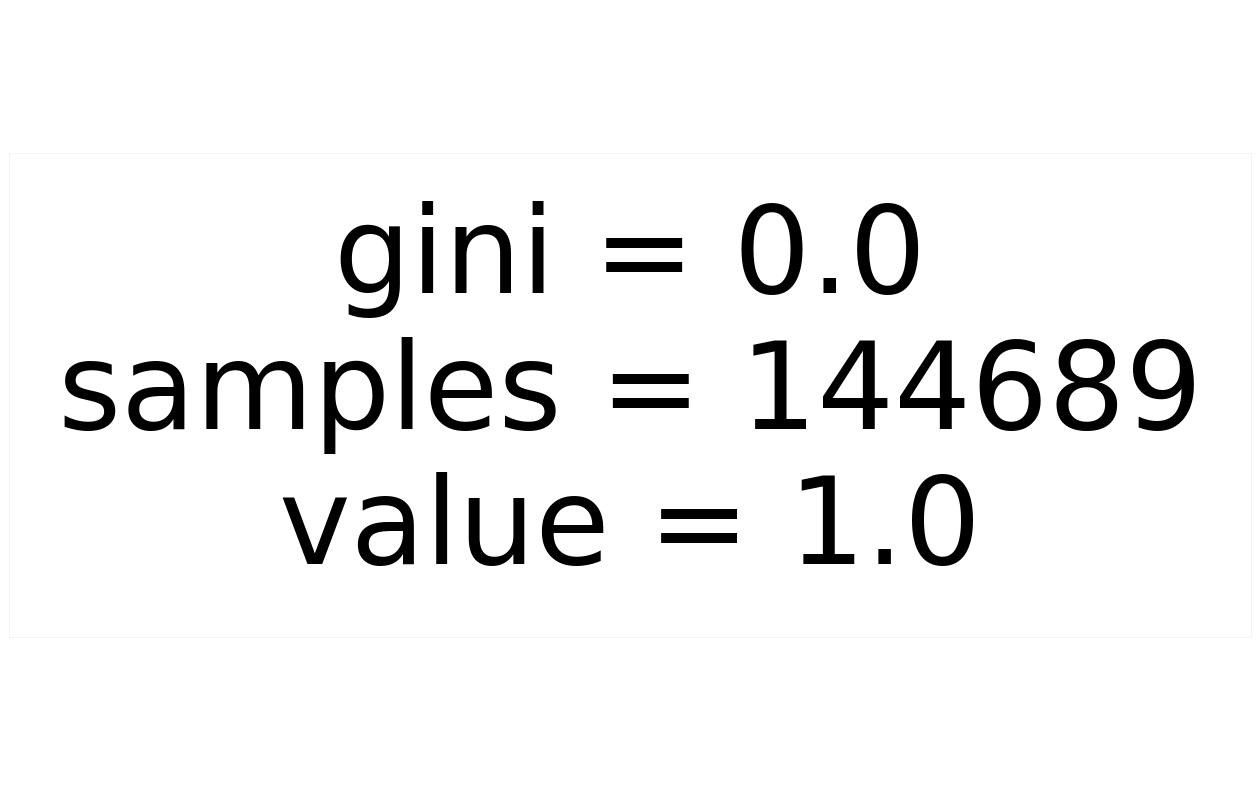

In [51]:
# Recode marital status into binary: 1 = Married, 0 = Unmarried
lfs_data['PUFC06_MSTAT_BINARY'] = lfs_data['PUFC06_MSTAT'].apply(lambda x: 1 if x == 2 else 0)

# Automatically classify individuals under 18 as unmarried
lfs_data.loc[lfs_data['PUFC05_AGE'] < 18, 'PUFC06_MSTAT_BINARY'] = 0

# Split data into features and target
features = ['PUFC05_AGE', 'PUFC04_SEX', 'PUFC03_REL']
target = 'PUFC06_MSTAT_BINARY'

# Remove missing values
lfs_data = lfs_data.dropna(subset=features + [target])

# Split into training and testing sets
X = lfs_data[features]
y = lfs_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree model
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", report)

# Display the decision tree
plt.figure(figsize=(16, 10))
plot_tree(model, feature_names=features, class_names=["Unmarried", "Married"], filled=True)
plt.show()
